# Summary
I will define a `movement` as the recorded lever movement between a defined first to second threshold and back for the third threshold. This notebook is solely for detecting and saving each movement from a day.

__Note on possible movements:__

<img src="./images/analysis2_var_p_cases.jpg" width="500" height="500" />

This image lists some of the possible cases that could occur with movement. For our analysis, all of these movements will count. The first, second, and third thresholds are marked with stars, and the beginning of the movement window and ending of the movement window are marked with vertical lines.

The folder defined by `analysis0_folder` needs contain the processed `lever_data` as processed_lever_data_trial#.bin binary files. The extracted movements will have MVT0 subtracted off and be temporally aligned to be comparable. They will be saved to a movement_trial#.npy file also in the folder defined by `output_folder`. From this point forward, I'm using `np.save()` to save all analysis as 2D arrays since I'm assuming I don't need to reaccess or further process the entire giant data with C++ anymore.

__This notebook analyzes 1 day session.__

# What should be in analysis1 folder:
- movement_trial#.npy for each extracted movement
- buffered_movement_trial#.npy for each extracted movement with a 300 sample buffer on either side

### imports and plot settings:

In [268]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

In [269]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.autolayout"] = True

### set folder_name and day, `trial_i_to_start` and `num_trials`
- `trial_i_to_start` and `num_trials` is based on preprocessing alignment (see analysis0 notebooks) and can be found for each day's session in the Google sheets analysis log

In [270]:
name = 'ANB2'
session = '20231030_d5'
trial_i_to_start = 0
num_trials = 98

In [271]:
tone_discriminiation_mat_file = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
analysis0_folder = "../Data_Copy/AnalysisData/"+name+"/analysis0_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/analysis1_"+name+"_"+session+"/"
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANB2/analysis1_ANB2_20231030_d5/: File exists


### extract one day's data from corresponding .mat file

In [272]:
mat_dict = io.loadmat(tone_discriminiation_mat_file)

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### find all movements from trials that meet both thresholds
each `movement` is a list: 5 elements `trial_i` |  `movement_lever_ts` | `movement_lever_data` | `movement_lever_ts` | `buffered_movement_lever_data`

`movements` is a list of `movements`


_Note that /0.0049 *5 /1023 converts from VBP's voltage to LeverData voltage_

also find `buffered_movement_lever_data` for making windows for higher order derivative filters later
- `buffered_movement_lever_data` is the same thing except it includes 300 previous sample points and 300 extra after sample points, which should always exist because the foreperiod duration should hopefully always be at least 7.5 ms

In [273]:
# get `respMTX` (trials) from response
respMTX = response[2]

MVT0 = respMTX[0, 4] * -1
print("MVT0 for all trials should be the same: ", MVT0)
mvt_threshold = params[7][0][0][0][0][0] /0.0049 *5 /1023 # VBP's conversion rate is not exact
print("mvt threshold: ", mvt_threshold, "+ MVT0 = ", MVT0 + mvt_threshold)
nomvt_threshold = params[7][0][0][1][0][0] /0.0049 *5 /1023
print("nomvt threshold: ", nomvt_threshold, "+ MVT0 = ", MVT0 + nomvt_threshold)

MVT0 for all trials should be the same:  2.42403
mvt threshold:  0.17954395834580164 + MVT0 =  2.6035739583458017
nomvt threshold:  0.11969597223053444 + MVT0 =  2.5437259722305345


In [274]:
# Parameters for extracting movements:
first_threshold = MVT0 + nomvt_threshold
second_threshold = MVT0 + mvt_threshold
third_threshold = MVT0 + nomvt_threshold

rewarded_trials = 0
movements = []
rejected_reward_movements = []
for trial_i in range(trial_i_to_start, num_trials):
    # only consider trials where there was a tone, there was a lever press, and there was a reward
    if ~np.isnan(respMTX[trial_i, 1]) and ~np.isnan(respMTX[trial_i, 3]) and respMTX[trial_i, 6] == 1:
        rewarded_trials += 1

        # Read the binary file created by the C++ program which is saved as double for both trial_frequencies and lever_data
        trial_frequencies = np.fromfile(analysis0_folder+"trial_frequencies.bin", dtype=np.double)
        fs = trial_frequencies[trial_i]
        lever_data = np.fromfile(analysis0_folder+"processed_trial"+str(trial_i)+".bin", dtype=np.double)
        num_samples = lever_data.shape[0]
        trial_start_time = respMTX[trial_i, 0]
        lever_ts = np.linspace(trial_start_time, trial_start_time + ((1/fs)*num_samples), num=num_samples)

        # get the row in lever_data for tone_t
        tone_t = respMTX[trial_i, 1]
        for lever_i, lever_t in enumerate(lever_ts):
            if tone_t <= lever_t:
                tone_lever_i = lever_i
                break
            
        # get the row in lever_data for lever_pressed_t
        # for checking the voltage at which reward was actually given
        lever_pressed_t = respMTX[trial_i, 3]
        for lever_i, lever_t in enumerate(lever_ts):
            if lever_pressed_t <= lever_t:
                lever_pressed_lever_i = lever_i
                break
        print("rewarded @ ", lever_data[lever_pressed_lever_i], "V")

        # First Threshold
        first_threshold_lever_i = 0
        for lever_i, lever_value in enumerate(lever_data[\
            tone_lever_i:\
            ]):
            if lever_value >= first_threshold:
                first_threshold_lever_i = lever_i + tone_lever_i
                break

        # Second Threshold
        second_threshold_lever_i = 0
        for lever_i, lever_value in enumerate(lever_data[\
            first_threshold_lever_i:\
            ]):
            if lever_value >= second_threshold:
                second_threshold_lever_i = lever_i + first_threshold_lever_i
                break
        
        # Third Threshold
        third_threshold_lever_i = 0
        for lever_i, lever_value in enumerate(lever_data[\
            second_threshold_lever_i:\
            ]):
            if lever_value <= third_threshold:
                third_threshold_lever_i = lever_i + second_threshold_lever_i
                break

        # if both first threshold and second threshold and third threshold are met, add to movements
        if (first_threshold_lever_i != 0) and (second_threshold_lever_i !=0) and (third_threshold_lever_i !=0):
            # add the movement itself
            movement_lever_ts = lever_ts[first_threshold_lever_i:third_threshold_lever_i]
            movement_lever_data = lever_data[first_threshold_lever_i:third_threshold_lever_i]

            # add its corresponding buffered_movement
            buffered_movement_lever_ts = lever_ts[first_threshold_lever_i-300:third_threshold_lever_i+300]
            buffered_movement_lever_data = lever_data[first_threshold_lever_i-300:third_threshold_lever_i+300]

            # add these both to `movements`
            movements.append([trial_i, movement_lever_ts, movement_lever_data, buffered_movement_lever_ts, buffered_movement_lever_data])

        else:
            not_met = ""
            if (first_threshold_lever_i == 0):
                not_met = not_met + "1st "
            if (second_threshold_lever_i == 0):
                not_met = not_met + "2nd "
            if (third_threshold_lever_i == 0):
                not_met = not_met + "3rd "
            movement_lever_ts = lever_ts[tone_lever_i:]
            movement_lever_data = lever_data[tone_lever_i:]
            rejected_reward_movements.append([trial_i, movement_lever_ts, movement_lever_data])
            print("ERROR: rewarded, but not all thresholds met during trial ", trial_i, ": ", not_met)

print("number of rewarded trials: ", rewarded_trials)
print("number of extracted_movements ", len(movements))

rewarded @  2.646279532760865 V
rewarded @  2.582375784742229 V
rewarded @  2.6153688582851085 V
rewarded @  2.6606026936447194 V
rewarded @  2.642448396039613 V
rewarded @  2.642207951313772 V
number of rewarded trials:  6
number of extracted_movements  6


check by plotting movements that are MVT0 subtracted and temporally aligned:

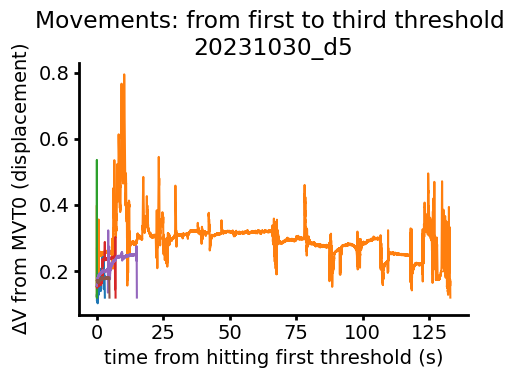

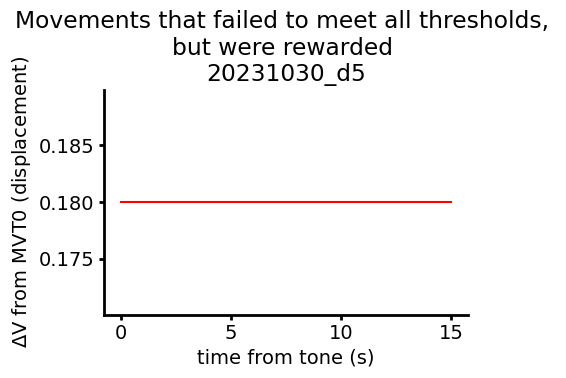

In [275]:
for movement in movements:
    # also check by plotting all of the movements
    plt.plot(\
        movement[1] - movement[1][0],\
        movement[2] - MVT0\
        )
plt.title("Movements: from first to third threshold \n"+session)
plt.xlabel("time from hitting first threshold (s)")
plt.ylabel("$\Delta$V from MVT0 (displacement)")
plt.show()

plt.title("Movements that failed to meet all thresholds, \nbut were rewarded \n"+session)
for movement in rejected_reward_movements:
    # also check by plotting all of the movements
    plt.plot(\
        movement[1] - movement[1][0],\
        movement[2] - MVT0\
        )
plt.xlabel("time from tone (s)")
plt.plot([0,15],[0.18, 0.18], color='red')
plt.ylabel("$\Delta$V from MVT0 (displacement)")
plt.show()

### Save these MVT0 subtracted and temporally aligned movements from `movements` into separate "movement_trial#" .npy files
`movement_data`: first row is times, second row is lever data

In [276]:
for movement in movements:
    trial_i = movement[0]
    
    movement_data = np.array([movement[1] - movement[1][0], \
                              movement[2] - MVT0])
    buffered_movement_data = np.array([movement[3] - movement[3][0], \
                              movement[4] - MVT0])
    
    np.save(output_folder+"movement_trial"+str(trial_i), movement_data)
    np.save(output_folder+"buffered_movement_trial"+str(trial_i), buffered_movement_data)